# Data Exploration

In [34]:
# File handling and manipulation
import os  # Provides functions for interacting with the operating system, such as reading and writing files and directories.
import shutil  # Offers high-level file operations like copying and moving files.
from PIL import Image  # Python Imaging Library (PIL) for opening, manipulating, and saving image files.

# Data manipulation and analysis
import pandas as pd  # Data analysis and manipulation library providing data structures like DataFrames.
import numpy as np  # Provides support for large arrays and matrices, along with mathematical functions to operate on these arrays.

# Geospatial data and image processing
import rasterio  # Library for reading and writing geospatial raster data.
from rasterio.enums import Resampling # Enum for resampling methods used in rasterio.
from rasterio.plot import show  # Function for visualizing raster data.
from skimage import exposure  # Image processing functions for contrast adjustment, filtering, and more.

# Visualization and plotting
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations in Python.
import seaborn as sns  # Data visualization library based on matplotlib, providing a high-level interface for drawing attractive statistical graphics.

# Utilities
import random  # Provides functions for generating random numbers and performing random operations.
from tqdm import tqdm  # Library for displaying progress bars in loops or processes.
import textwrap  # Utilities for wrapping and formatting text to fit a specific width.

In [47]:
# Load the metadata
metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata.parquet')

# Base directories
source_base_dir = r'D:\datasets\2020-BigEarthNet-S2'
destination_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset'
split_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits'
test_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test'

In [37]:
# Extract unique labels from the metadata
unique_labels = metadata_df['labels'].explode().unique()

# Display the first few rows of the DataFrame with a preceding message
print("First few rows of the DataFrame:")
print(metadata_df.head())

First few rows of the DataFrame:
                                            patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   

                                              labels split  country  \
0  [Arable land, Broad-leaved forest, Mixed fores...  test  Austria   
1  [Arable land, Broad-leaved forest, Inland wate...  test  Austria   
2  [Arable land, Broad-leaved forest, Coniferous ...  test  Austria   
3  [Broad-leaved forest, Complex cultivation patt...  test  Austria   
4  [Broad-leaved forest, Complex cultivation patt...  test  Austria   

                                        s1_name  \
0  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_26_57   
1  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_55   
2  S1B_IW_GRDH_1SDV_20170612T165809_33UUP_27_56   

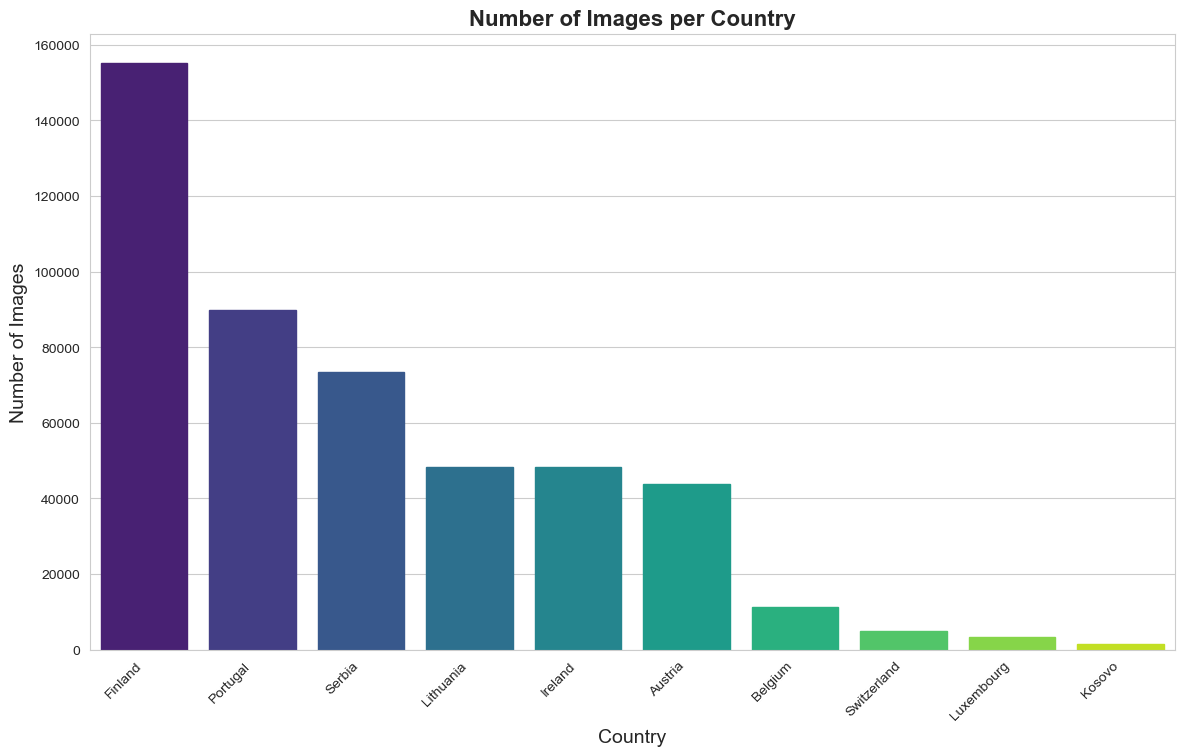

In [42]:
# Count the number of images per country
country_counts = metadata_df['country'].value_counts()

# Prepare data for bar graph
country_df = country_counts.reset_index()
country_df.columns = ['Country', 'Number of Images']

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar graph
plt.figure(figsize=(14, 8))  # Adjust the figure size as needed

# Plot the bar graph without `palette`
ax = sns.barplot(x='Country', y='Number of Images', data=country_df)

# Apply color palette manually
colors = sns.color_palette('viridis', len(country_df))
for bar, color in zip(ax.patches, colors):
    bar.set_color(color)

# Add labels and title
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Number of Images per Country', fontsize=16, weight='bold')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Display the bar graph
plt.show()

Displaying Images: 100%|██████████| 19/19 [00:00<00:00, 28.29image/s]


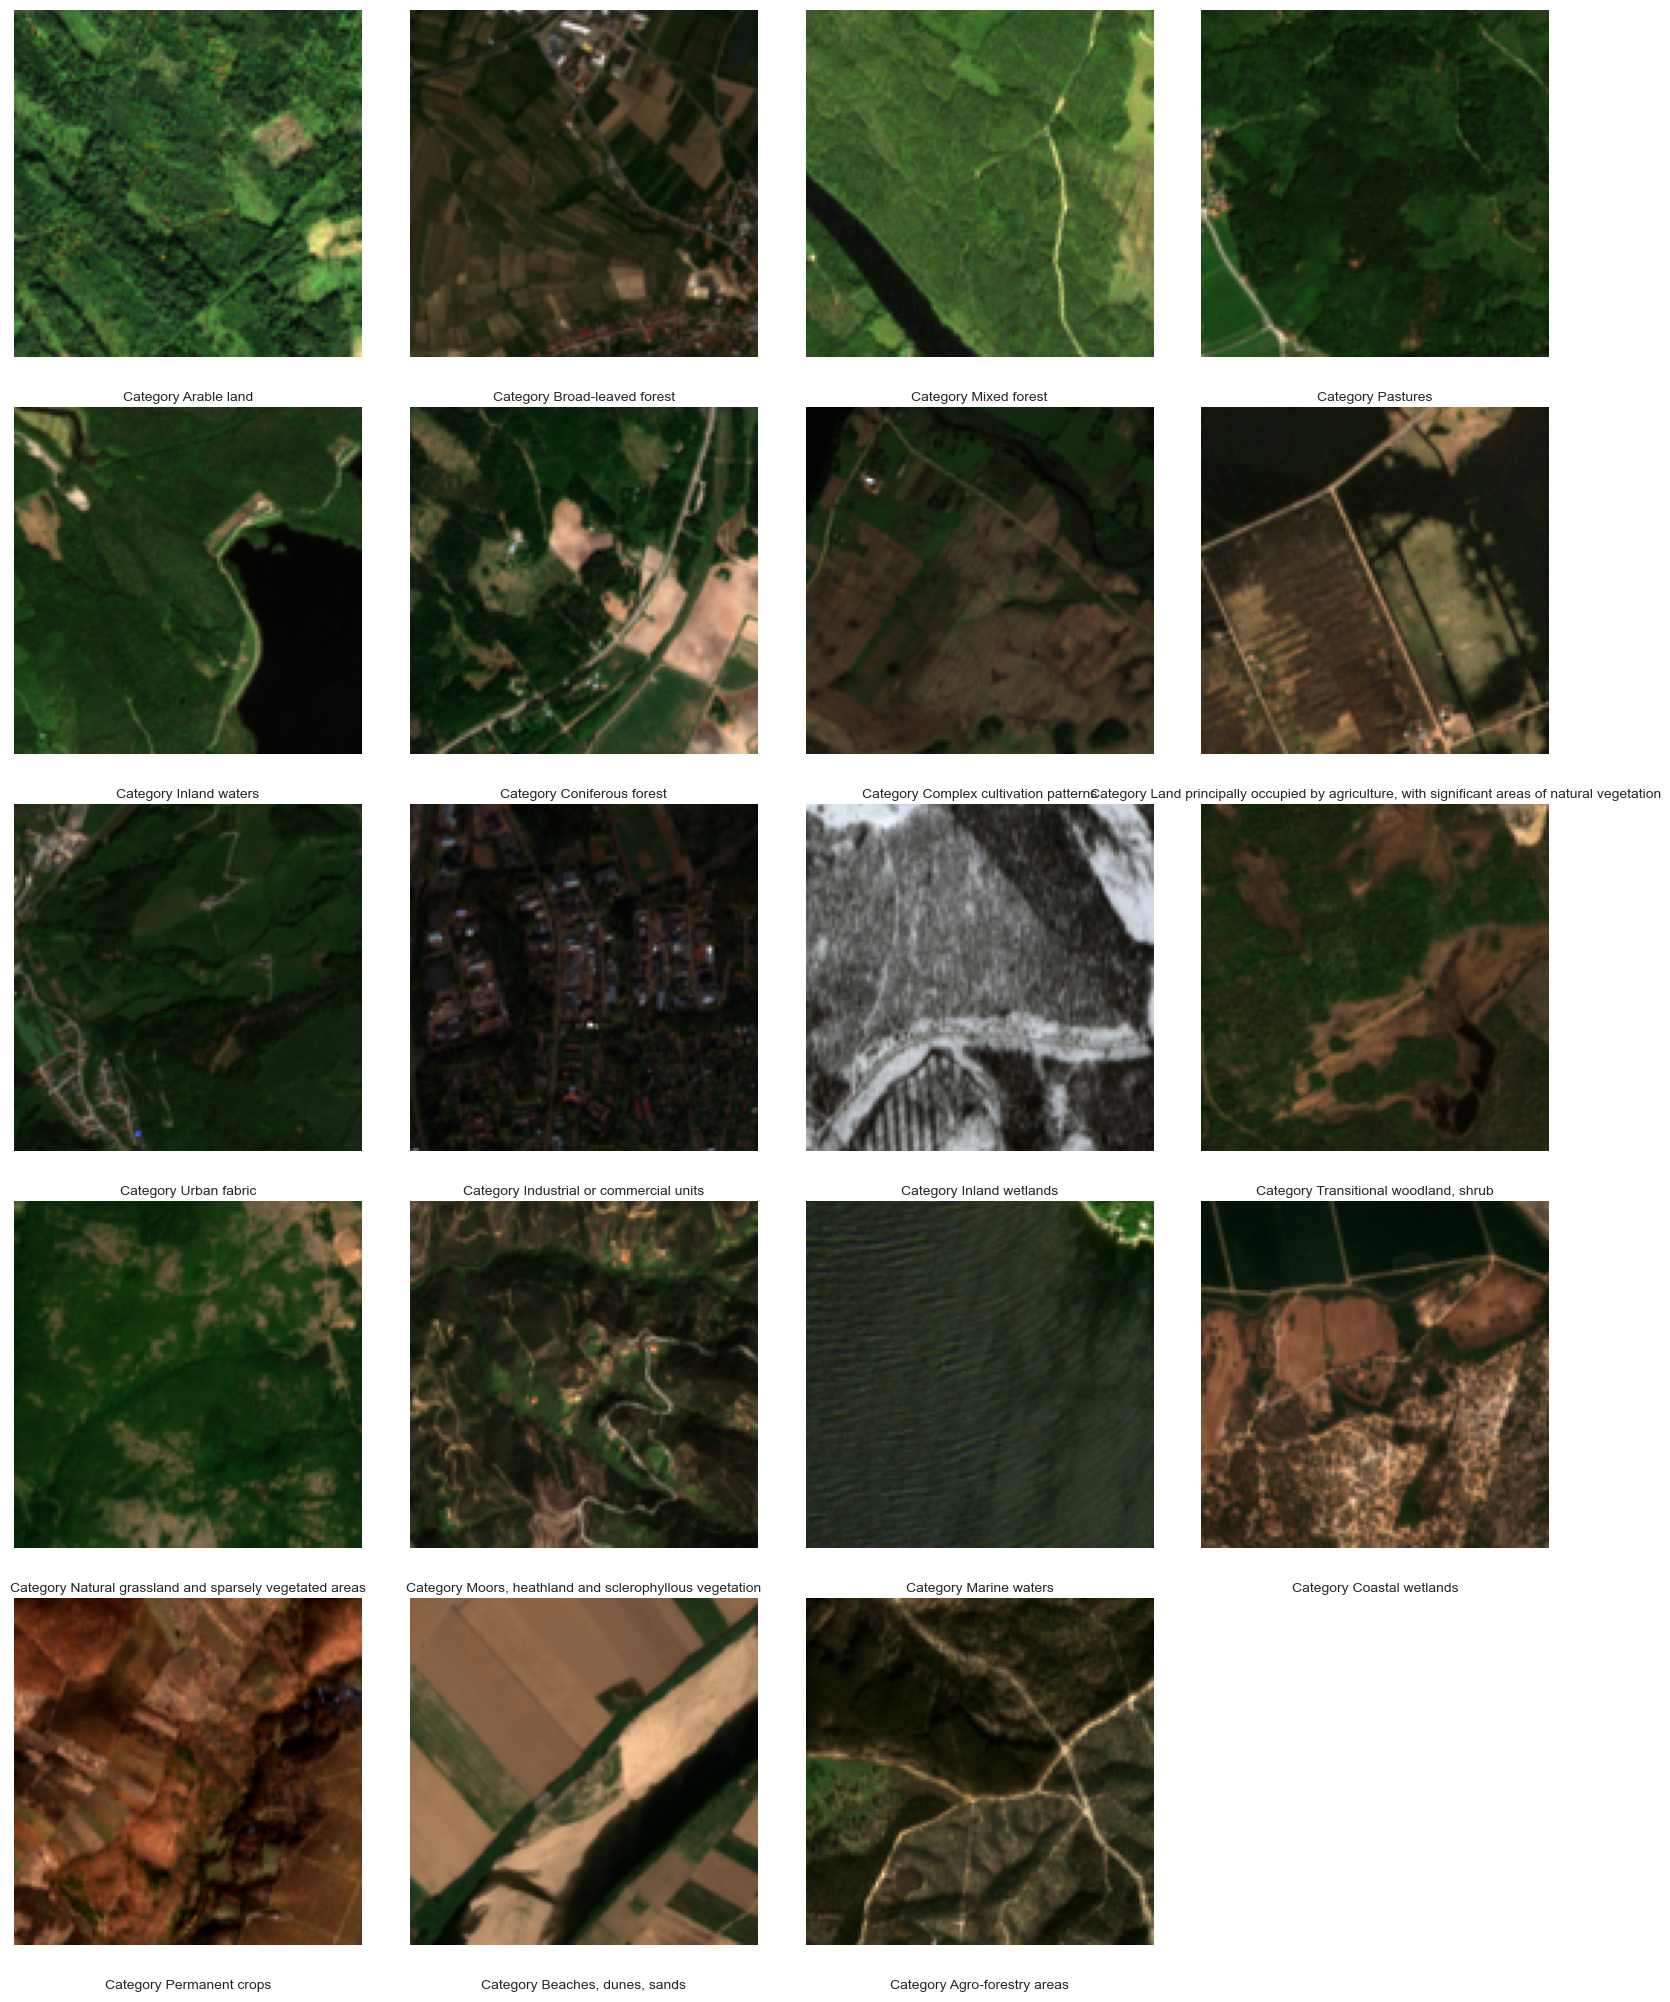

In [51]:
# List to store image paths
image_paths = []

# Iterate over each category with a progress bar
for category in tqdm(unique_labels, desc="Processing Categories", unit="category"):
    # Construct the directory path for the current category
    category_path = os.path.join(test_base_dir, category)
    
    # Check if the directory exists
    if not os.path.exists(category_path):
        print(f"Directory not found: {category_path}")
        continue
    
    # Get the list of folders in the category
    folders = [f for f in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, f))]

    if len(folders) > 0:
        # Select a random folder in the category
        selected_folder = random.choice(folders)
        selected_folder_path = os.path.join(category_path, selected_folder)

        # Collect .tif files in the folder
        tif_files = [file for file in os.listdir(selected_folder_path) if file.lower().endswith('.tif')]
        
        if len(tif_files) >= 4:
            # Sort files to ensure consistent selection of bands
            tif_files.sort()
            # Construct full paths for the second, third, and fourth bands
            band_files = [os.path.join(selected_folder_path, tif_files[i]) for i in range(1, 4)]  # Bands 2, 3, 4
            
            image_paths.append(band_files)
        else:
            print(f"Not enough .tif files in folder: {selected_folder_path}")

# Calculate the number of rows and columns
num_images = len(image_paths)
num_cols = min(4, num_images)  # Set a max number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure to display the images
plt.figure(figsize=(num_cols * 4, num_rows * 4))

# Iterate over each set of band files with a progress bar
for i, band_files in tqdm(enumerate(image_paths, start=1), total=num_images, desc="Displaying Images", unit="image"):
    plt.subplot(num_rows, num_cols, i)
    
    try:
        # Read the bands and stack them
        with rasterio.open(band_files[2]) as b2, rasterio.open(band_files[1]) as b3, rasterio.open(band_files[0]) as b4:
            band2 = b2.read(1)  # Read band 2
            band3 = b3.read(1)  # Read band 3
            band4 = b4.read(1)  # Read band 4
            
            # Stack bands into a 3-channel image (RGB)
            img = np.stack([band2, band3, band4], axis=-1)
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for visualization
            
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Category {unique_labels[i-1]}", fontsize=10, y=-0.15)
    except Exception as e:
        print(f"Error reading image bands {band_files}: {e}")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

In [33]:
# Initialize a dictionary to hold the count of subfolders in each folder
folder_subfolder_counts = {}

# Iterate through each item in the base directory with a progress bar
for folder in tqdm(os.listdir(test_base_dir), desc="Processing Folders", unit="folder"):
    folder_path = os.path.join(test_base_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # List all subdirectories within the current folder
        subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]
        
        # Count the number of subfolders
        subfolder_count = len(subfolders)
        
        # Store the count in the dictionary
        folder_subfolder_counts[folder] = subfolder_count

# Sort the dictionary by subfolder count in descending order
sorted_folder_counts = sorted(folder_subfolder_counts.items(), key=lambda x: x[1], reverse=True)

# Print header
print(f"{'Folder Name':<70} {'Subfolder Count':>15}")
print("-" * 85)

# Print the sorted number of subfolders in each folder in a formatted manner
for folder, count in sorted_folder_counts:
    print(f"{folder:<70} {count:>15}")

Processing Folders: 100%|██████████| 1/1 [00:00<00:00, 444.31folder/s]

Folder Name                                                            Subfolder Count
-------------------------------------------------------------------------------------
dataset_splits                                                                       3


In [ ]:
# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Folder', y='Subfolder Count', data=df_folder_counts, palette='viridis')

# Add titles and labels
plt.title('Number of Subfolders per Folder', fontsize=16)
plt.xlabel('Folder Name', fontsize=14)
plt.ylabel('Number of Subfolders', fontsize=14)
plt.xticks(rotation=90)  # Rotate folder names if they are long

# Show the plot
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()

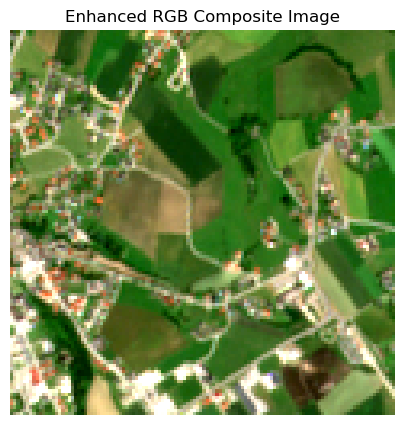

Enhanced image saved to D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\output_image2.png


In [25]:
# File paths to the bands (modify these paths to your actual file locations)
band4_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B04.tif'  # Red band
band3_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B03.tif'  # Green band
band2_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B02.tif'  # Blue band

# Open the bands using Rasterio
with rasterio.open(band4_path) as band4, \
     rasterio.open(band3_path) as band3, \
     rasterio.open(band2_path) as band2:
    
    # Read each band into an array
    red = band4.read(1)
    green = band3.read(1)
    blue = band2.read(1)
    
    # Stack the bands to create an RGB image
    rgb = np.stack((red, green, blue), axis=-1)
    
    # Apply percentile clipping for normalization
    p2, p98 = np.percentile(rgb, (2, 98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))
    
    # Optionally, apply gamma correction
    gamma = 0.8
    rgb = np.power(rgb, gamma)
    
    # Convert to 8-bit image
    rgb = (255 * (rgb / np.max(rgb))).astype(np.uint8)
    
    # Save the RGB image as a PNG file
    output_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\output_image2.png'
    Image.fromarray(rgb).save(output_path, format='PNG', optimize=True)

    # Display the RGB image
    plt.figure(figsize=(5, 5))
    plt.imshow(rgb)
    plt.title("Enhanced RGB Composite Image")
    plt.axis('off')
    plt.show()

print(f"Enhanced image saved to {output_path}")


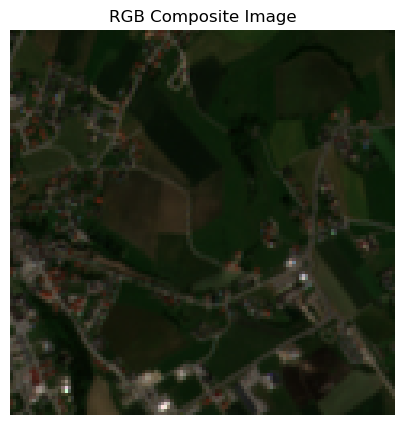

Image saved to D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\output_image.png


In [24]:
# File paths to the bands (modify these paths to your actual file locations)
band4_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B04.tif'  # Red band
band3_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B03.tif'  # Green band
band2_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B02.tif'  # Blue band

# Open the bands using Rasterio
with rasterio.open(band4_path) as band4, \
     rasterio.open(band3_path) as band3, \
     rasterio.open(band2_path) as band2:
    
    # Read each band into an array
    red = band4.read(1)
    green = band3.read(1)
    blue = band2.read(1)
    
    # Stack the bands to create an RGB image
    rgb = np.stack((red, green, blue), axis=-1)
    
    # Normalize the bands if necessary (scale to 0-255)
    rgb = rgb.astype(np.float32)
    rgb = (255 * (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))).astype(np.uint8)
    
    # Save the RGB image as a PNG file
    output_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\output_image.png'
    Image.fromarray(rgb).save(output_path)

    # Display the RGB image
    plt.figure(figsize=(5, 5))
    plt.imshow(rgb)
    plt.title("RGB Composite Image")
    plt.axis('off')
    plt.show()

print(f"Image saved to {output_path}")

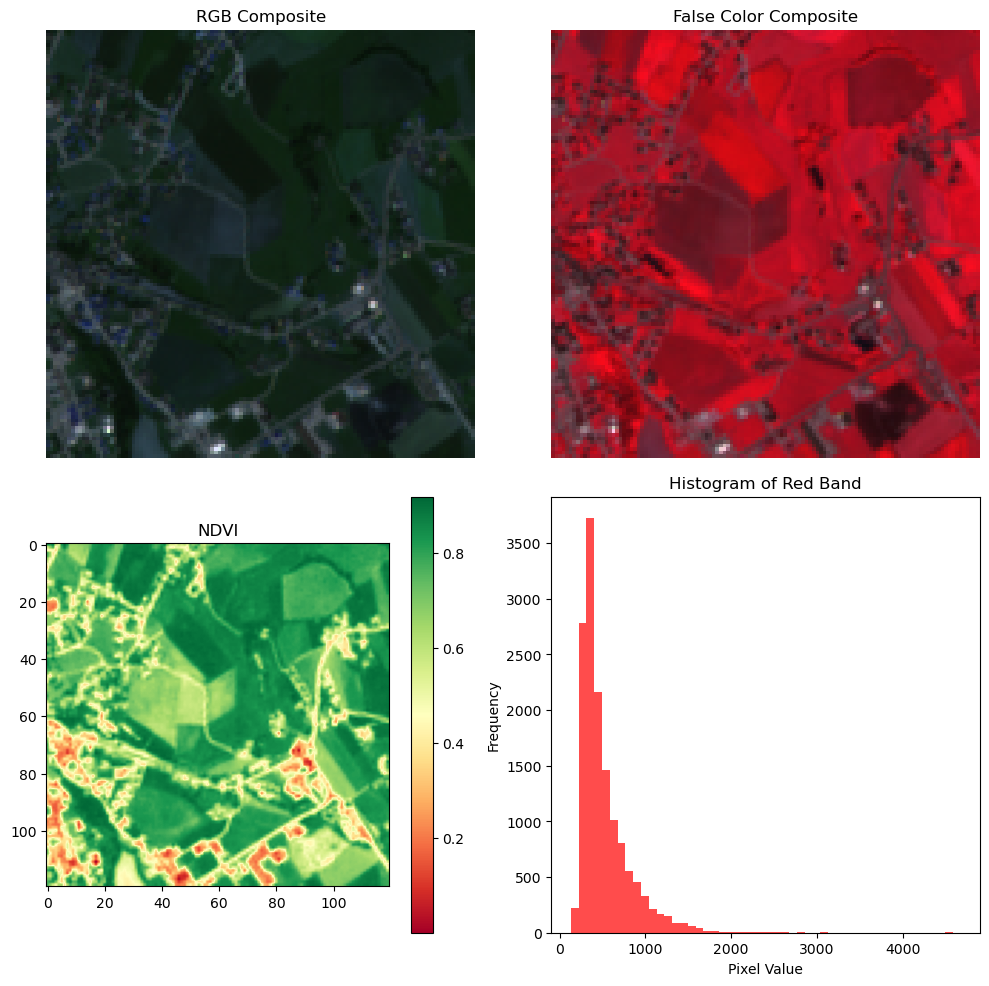

In [19]:
# File paths to the bands
band4_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B02.tif'  # Red band
band3_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B03.tif'
band2_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B04.tif'
nir_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test\Urban fabric\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_32_63_B08.tif'  # NIR band

# Open the bands using Rasterio
with rasterio.open(band4_path) as band4, \
     rasterio.open(band3_path) as band3, \
     rasterio.open(band2_path) as band2, \
     rasterio.open(nir_path) as nir_band:
    
    red = band4.read(1)
    green = band3.read(1)
    blue = band2.read(1)
    nir = nir_band.read(1)
    
    # RGB Composite
    rgb = np.stack((red, green, blue), axis=-1)
    rgb = rgb / np.max(rgb)
    
    # False Color Composite (NIR, Red, Green)
    false_color = np.stack((nir, red, green), axis=-1)
    false_color = false_color / np.max(false_color)
    
    # NDVI
    ndvi = (nir - red) / (nir + red)
    
    # Display results
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Composite")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(false_color)
    plt.title("False Color Composite")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.title("NDVI")
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.hist(red.ravel(), bins=50, color='red', alpha=0.7)
    plt.title("Histogram of Red Band")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


In [9]:
# Define the patch_id you're interested in
target_patch_id = 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_31_58'  # Replace with your specific patch_id

# Filter the DataFrame to get the row with the matching patch_id
matching_row = metadata_df.loc[metadata_df['patch_id'] == target_patch_id]

# If a match is found, extract the labels
if not matching_row.empty:
    labels = matching_row['labels'].values[0]
    split = matching_row['split'].values[0]
    print(f'Labels for patch_id {target_patch_id}: {labels}')
    print(f'Split: {split}')
else:
    print(f'No matching patch_id found for {target_patch_id}')


Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_31_58: ['Arable land' 'Coniferous forest'
 'Land principally occupied by agriculture, with significant areas of natural vegetation'
 'Pastures']
Split: test


In [10]:
# Define the patch_id you're interested in
target_patch_id = 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_57'  # Replace with your specific patch_id

# Filter the DataFrame to get the row with the matching patch_id
matching_row = metadata_df.loc[metadata_df['patch_id'] == target_patch_id]

# If a match is found, extract the labels
if not matching_row.empty:
    labels = matching_row['labels'].values[0]
    split = matching_row['split'].values[0]
    print(f'Labels for patch_id {target_patch_id}: {labels}')
    print(f'Split: {split}')
else:
    print(f'No matching patch_id found for {target_patch_id}')


Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_57: ['Broad-leaved forest' 'Complex cultivation patterns' 'Coniferous forest'
 'Inland waters' 'Mixed forest']
Split: test


In [2]:
# Read the data
metadata_df = pd.read_parquet(r'C:\Users\isaac\Desktop\SampleBigEarth\metadata.parquet')

# Convert numpy.ndarray to list if necessary
metadata_df['labels'] = metadata_df['labels'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Filter rows where 'labels' contain only "Arable land"
arable_land_only = metadata_df[metadata_df['labels'].apply(lambda x: x == ['Arable land'])]

# Count the number of such rows
num_arable_land_only = arable_land_only.shape[0]
print(f"Number of records with the label 'Arable land' uniquely: {num_arable_land_only}")

# Filter rows where 'labels' contain "Arable land" among other labels
arable_land_present = metadata_df[metadata_df['labels'].apply(lambda x: 'Arable land' in x and len(x) > 1)]

# Count the number of such rows
num_arable_land_present = arable_land_present.shape[0]
print(f"Number of records with 'Arable land' among other labels: {num_arable_land_present}")

# Define the target labels
target_labels = ['Arable land', 'Mixed forest', 'Coniferous forest']

# Filter rows where 'labels' contain exactly the target labels
exact_three_labels = metadata_df[metadata_df['labels'].apply(lambda x: sorted(x) == sorted(target_labels))]

# Count the number of such rows
num_exact_three_labels = exact_three_labels.shape[0]
print(f"Number of records with exactly the labels 'Arable land', 'Mixed forest', and 'Coniferous forest': {num_exact_three_labels}")

Number of records with the label 'Arable land' uniquely: 14893
Number of records with 'Arable land' among other labels: 173132
Number of records with exactly the labels 'Arable land', 'Mixed forest', and 'Coniferous forest': 3815


In [27]:
num_rows = updated_metadata_df.shape[0]
print(f"The DataFrame contains {num_rows} rows.")

print()

# Convert numpy.ndarray to list if necessary
updated_metadata_df['labels'] = updated_metadata_df['labels'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Count the number of labels per record
updated_metadata_df['label_count'] = updated_metadata_df['labels'].apply(len)

# Get the counts for each label count
single_label_count = updated_metadata_df[updated_metadata_df['label_count'] == 1].shape[0]
two_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 2].shape[0]
three_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 3].shape[0]
four_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 4].shape[0]
five_labels_count = updated_metadata_df[updated_metadata_df['label_count'] >= 5].shape[0]
# Print the results
print(f"Number of records with a single label: {single_label_count}")
print(f"Number of records with 2 labels: {two_labels_count}")
print(f"Number of records with 3 labels: {three_labels_count}")
print(f"Number of records with 4 labels: {four_labels_count}")
print(f"Number of records with 5 labels: {five_labels_count}"'\n')

# Calculate the total number of records
total_records = (single_label_count + two_labels_count + three_labels_count +
                 four_labels_count + five_labels_count)

# Print the total number of records
print(f"Total number of records: {total_records}")

The DataFrame contains 480038 rows.

Number of records with a single label: 86375
Number of records with 2 labels: 94649
Number of records with 3 labels: 135885
Number of records with 4 labels: 102036
Number of records with 5 labels: 61093

Total number of records: 480038


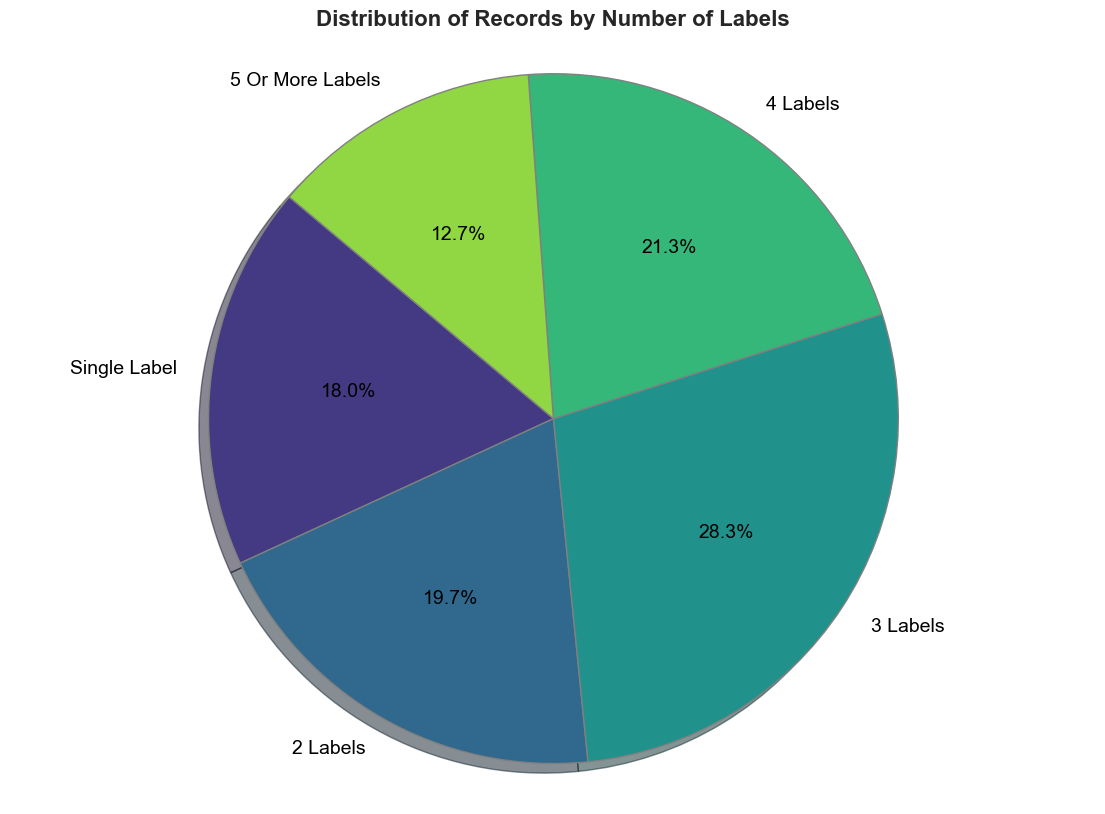

In [32]:
# Set Seaborn style
sns.set_style("whitegrid")

# Data for the pie chart
sizes = [single_label_count, two_labels_count, three_labels_count, four_labels_count, five_labels_count]
labels = ['Single Label', '2 Labels', '3 Labels', '4 Labels', '5 Or More Labels']

# Use 'viridis' color palette from Seaborn
colors = sns.color_palette('viridis', len(sizes))  # Adjust the number of colors as needed

# Create the pie chart
plt.figure(figsize=(14, 10))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        shadow=True, textprops={'fontsize': 14, 'color': 'black'}, wedgeprops={'edgecolor': 'grey'})

# Title of the pie chart
plt.title('Distribution of Records by Number of Labels', fontsize=16, weight='bold')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.savefig('images/distribution_of_records_by_labels_piechart.png')  # Ensure the path is correct
plt.show()

In [23]:
# Get the count of records with exactly 1 label that is "Arable land"
one = updated_metadata_df[
    (updated_metadata_df['label_count'] == 1) &
    (updated_metadata_df['labels'].apply(lambda x: x == ['Arable land']))
].shape[0]

print(f"Number of records with exactly 1 label and the label is 'Arable land': {one}")

# Get the count of records with exactly 2 labels that are "Arable land" and "Mixed forest"
two = updated_metadata_df[
    (updated_metadata_df['label_count'] == 2) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest'}))
].shape[0]

print(f"Number of records with exactly 2 labels 'Arable land' and 'Mixed forest': {two}")

# Get the count of records with exactly 3 labels that are "Arable land", "Mixed forest" and "Coniferous forest"
three = updated_metadata_df[
    (updated_metadata_df['label_count'] == 3) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest' and 'Coniferous forest' : {three}")

# Get the count of records with exactly 3 labels that are "Arable land", "Mixed forest", "Coniferous forest" and "Transitional woodland, shrub"
four = updated_metadata_df[
    (updated_metadata_df['label_count'] == 4) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest' and 'Transitional woodland, shrub': {four}")

five = updated_metadata_df[
    (updated_metadata_df['label_count'] == 5) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub', 'Broad-leaved forest'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub' and 'Broad-leaved forest': {five}")


Number of records with exactly 1 label and the label is 'Arable land': 14893
Number of records with exactly 2 labels 'Arable land' and 'Mixed forest': 1507
Number of records with exactly 3 labels 'Arable land', 'Mixed forest' and 'Coniferous forest' : 3815
Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest' and 'Transitional woodland, shrub': 3216
Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub' and 'Broad-leaved forest': 493


In [ ]:
# Extract unique labels from the metadata and sort
unique_labels = metadata_df['labels'].explode().unique()
all_labels = sorted(unique_labels)  # Ensure all_labels is sorted

# Create a dictionary to map label names to indices
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Function to convert label list to binary vector
def labels_to_vector(label_list):
    vector = [0] * len(all_labels)
    for label in label_list:
        index = label_to_index[label]
        vector[index] = 1
    return vector

# Apply the conversion to the 'labels' column
metadata_df['label_vector'] = metadata_df['labels'].apply(labels_to_vector)

# Save the updated DataFrame with the label_vector to a Parquet file
metadata_df.to_parquet('updated_metadata_with_vectors.parquet', index=False)

In [ ]:
updated_metadata_df = pd.read_parquet(r'C:\Users\isaac\FYPCode\updated_metadata_with_vectors.parquet')

num_rows = updated_metadata_df.shape[0]
print(f"The DataFrame contains {num_rows} rows.\n")

# Display the column names
print("Column Names:")
print(updated_metadata_df.columns, "\n")

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(updated_metadata_df.head())